# Data Exploration
On this notebook we will explore the different categories of the dataset and select our final dataset on which the web aplication will be built on.

## Dataset considerations
- Dataset only includes female clothing
- Retrieval images refer to the store images. Customer images replicate the images a customer would upload to the store.
- Some customer images match more than 1 product from different categories ie. shoes + dress + bag in the same photo.
- Some items in the customer images are heavily duplicated, ie. product id "7182" from customer returns 285 images of the same item
- Some labels in the customer images dataframe are duplicates but they have more than 1 bounding box because the same piece of clothing appears >1 on the image, there are also ocassions where an incorrect bounding box has been included.
- Retrieval images from the same product are usually repeated from different angles, distances, etc. but not always. Only ~200k unique items.
- Original product ids start at 1 for every category, there is not a unique identifier other than the photo name.
- To find matches a combination of product id + category is used, however there may be many matches, there could be different customer photos of the same product and category and there will likely be more than 1 photo of the same product and category on the store. So matches all:all need to be taken into account.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
%matplotlib inline
pd.options.mode.chained_assignment = None  #disables .loc assignment warning
plt.style.use('seaborn-notebook')

In [2]:
def plot_freqs(df, title):
    """Given a dataframe, groups data based on clothing category and plots the frequencies"""
    ax = plt.subplot(111)
    df_freq = df["category"].value_counts().sort_values(ascending=True)
    df_freq.plot(
        kind="barh",
        title=title,
        color=(0.2, 0.4, 0.6, 0.6)
        )
    for i, n in enumerate(df["category"].value_counts().sort_values(ascending=True)):
        plt.text(s=n, x=n+200, y=i, verticalalignment="center")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tick_params(left=False)
    
    plt.show()

In [3]:
customer_df = pd.read_csv("./customer_df.csv")
retrieval_df = pd.read_csv("./retrieval_df.csv")

### Customer data exploration

In [4]:
print(customer_df.head(3))

   photo  product category          id  height   left    top  width
0   4534     7419     bags   7419_bags   358.0  134.0  172.0  120.0
1  16159     9946     bags   9946_bags   303.0  148.0  184.0  120.0
2   6538    10777     bags  10777_bags    88.0  100.0  310.0   57.0


In [5]:
print("Number of labels: ", customer_df.shape[0])
print("Max unique photo times repeated: ", customer_df["photo"].value_counts().sort_values(ascending=False).max())
print("Max unique product times repeated: ", customer_df["product"].value_counts().sort_values(ascending=False).max())
print("Unique photos: ", customer_df["photo"].unique().shape[0])
print("Unique products: ", customer_df["product"].unique().shape[0])

Number of labels:  28180
Max unique photo times repeated:  15
Max unique product times repeated:  153
Unique photos:  15495
Unique products:  8583


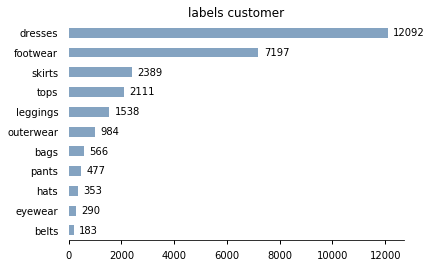

In [6]:
plot_freqs(customer_df, "labels customer")

### Retrieval data exploration

In [7]:
print(retrieval_df.head(3))

    photo  product category      id
0  206867        3     bags  3_bags
1  371076        4     bags  4_bags
2  374473        5     bags  5_bags


In [8]:
print("Total labels: ", retrieval_df.shape[0])
print("Max unique photo times repeated: ", retrieval_df["photo"].value_counts().sort_values(ascending=False).max())
print("Max unique  product times repeated: ", retrieval_df["product"].value_counts().sort_values(ascending=False).max())
print("Unique photos: ", retrieval_df["photo"].unique().shape[0])
print("Unique products: ", retrieval_df["product"].unique().shape[0])

Total labels:  320080
Max unique photo times repeated:  4
Max unique  product times repeated:  455
Unique photos:  319763
Unique products:  63735


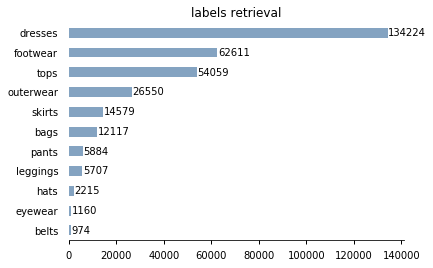

In [9]:
plot_freqs(retrieval_df, "labels retrieval")

### How to find pair matches:
First we will create a helper function to plot the images.  

Then, for example I want to find the matching pair for customer image "1.jpg"

In [10]:
def show_image(img_path, bbox=False):
    """Given an img_path it plots the image. Supports multicategory images and allows an option to plot all bboxes"""
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.imshow(mpimg.imread(img_path))
    ax.axis("off")
    
    if bbox == True:
        img_id = img_path.split("/")[-1].split(".")[0]
        img_data = customer_df[customer_df["photo"] == int(img_id)]
        
        if img_data["category"].unique().shape[0] > 1: #could have either more than 1 category or same category with different bboxes
            print("Categories: ", img_data["category"].value_counts().index.tolist())
            img_category = input("Please specify category: ")
            img_data = img_data[img_data["category"] == img_category]
            
        if img_data.shape[0] > 1: #if image have more than 1 bbox this will plot all of them
            for index, row in img_data.iterrows():
                top, left, width, height = int(row["top"]), int(row["left"]), int(row["width"]), int(row["height"])                
                rect = patches.Rectangle(xy=(left,top),width=width,height=height,linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            plt.show()
            return 
            
        top, left, width, height = int(img_data["top"]), int(img_data["left"]), int(img_data["width"]), int(img_data["height"])        
        rect = patches.Rectangle(xy=(left,top),width=width,height=height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()

In [11]:
#we index by its name on the customer df
customer_df[customer_df["photo"] == 1]
#2 results, we are interested in the dress

,photo,product,category,id,height,left,top,width
1922,1,65901,dresses,65901_dresses,1121.0,560.0,143.0,755.0
21396,1,14177,footwear,14177_footwear,375.0,661.0,1550.0,445.0


In [12]:
#we need to look on the retrieval data for the same id of the dress category
retrieval_df[(retrieval_df["id"] == "65901_dresses")]
#we get more than one photo since the same product has different images from different angles, zooms, etc

,photo,product,category,id
143950,62650,65901,dresses,65901_dresses
143951,62651,65901,dresses,65901_dresses
143952,62652,65901,dresses,65901_dresses


Categories:  ['footwear', 'dresses']
Please specify category: dresses


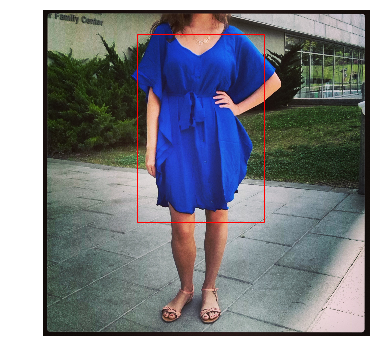

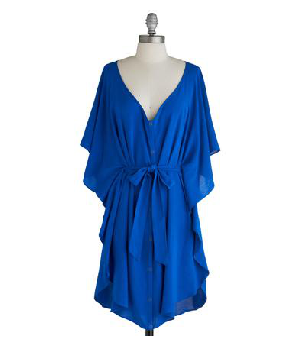

In [13]:
show_image("../photos_resized/1.jpg", bbox=True)
show_image("../photos_resized/62650.jpg")

## Total pair matches

In [14]:
matches_df = customer_df.merge(retrieval_df, how="inner", on="id", suffixes=("", "_retr"))

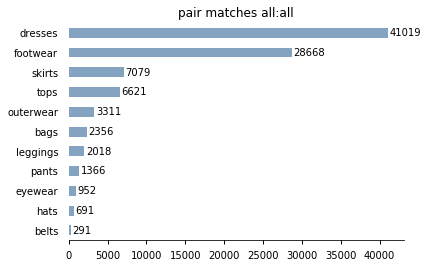

In [15]:
plot_freqs(matches_df, "pair matches all:all")

## Images with multiple label entries

This is due to 2 main reasons, multiple bboxes and multiple categories for the same image.

#### 1. Multiple bounding boxes
Here we will try to get an understanding of why would we have more that one bounding box, below we look at the images with the highest amount of bounding boxes

In [16]:
customer_df["photo_cat"] = customer_df["photo"].map(str) +"_"+ customer_df["category"] #helper column
customer_df["photo_cat"].value_counts().head(10) #top 10 by frequency

5670_dresses      12
15726_dresses     10
6963_dresses      10
4066_dresses      10
6140_dresses      10
2146_skirts        9
1049_skirts        8
329968_dresses     8
4561_dresses       8
11928_leggings     8
Name: photo_cat, dtype: int64

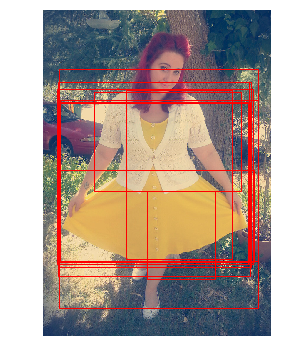

In [17]:
show_image("../photos_resized/5670.jpg", bbox=True)

Categories:  ['skirts', 'tops']
Please specify category: tops


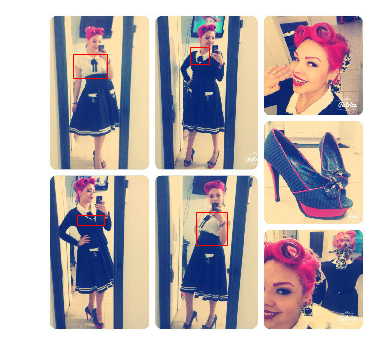

In [18]:
show_image("../photos_resized/1049.jpg", bbox=True)

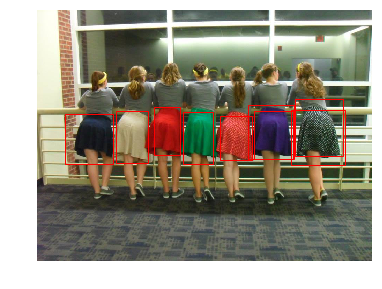

In [19]:
show_image("../photos_resized/2146.jpg", bbox=True)

There are a few issues that arise at this point.

- Some bounding boxes are not correct as per the first image.
- Some product have multiple bboxes. Which strategy should we take, should we take the box with the largest area? Take them all and average the result?, etc.
- Some photos have more than one product, this is a challenge since the final resolution and therefore the quality of the image will not be equal to an image a customer would usually upload to our final aplication.

#### 2. Multiple categories on same image
Another challenge inherent to this dataset is the fact that some images have been "recycled" to match more than one piece of clothing. Below we look at the images with the highest amount of categories.

In [20]:
top_categories = customer_df.drop_duplicates(subset=["photo_cat"])["photo"].value_counts().sort_values(ascending=False)
top_categories.head()

11849    6
10906    6
16881    6
9058     5
17398    5
Name: photo, dtype: int64

Categories:  ['leggings', 'tops', 'outerwear', 'footwear', 'dresses', 'bags']
Please specify category: footwear


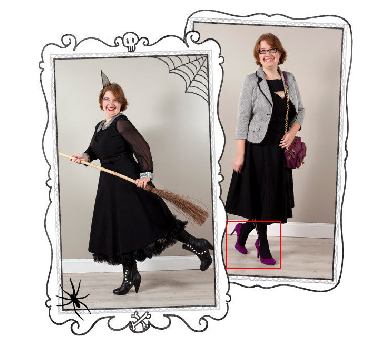

In [21]:
show_image("../photos_resized/11849.jpg", bbox=True)

Categories:  ['footwear', 'tops', 'dresses', 'belts', 'bags', 'outerwear']
Please specify category: bags


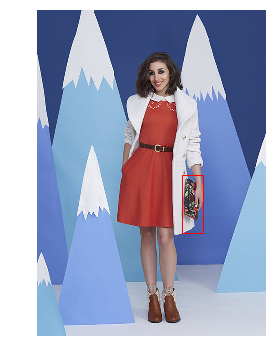

In [22]:
show_image("../photos_resized/10906.jpg", bbox=True)

Categories:  ['footwear', 'skirts', 'leggings', 'outerwear', 'tops', 'bags']
Please specify category: leggings


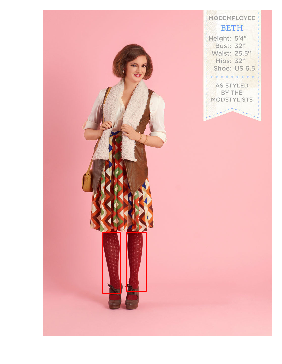

In [23]:
show_image("../photos_resized/16881.jpg", bbox=True)

Again, we start from the expectation that an customer interested in a particular piece of clothing would provide an image of a considerable size and quality and where the product is clearly on display.

The three examples above show images that have been used to match products from 6 different categories, this may work in some cases, usually with large clothing items such as dresses, but it hardly does for every single category represented on the image. 

Another point to consider is that these images will then need to be cropped down therefore reducing further more its size and impacting on the algorithm performance.

# Final Selection

At this point, we have decided to subset our dataset and stick to dresses and tops. This is due to several reasons:
- Volume of data for upper-body categories (dresses and tops)
- Dresses and tops images from customer usually show a fullbody image with a satisfactory size of the product in terms of expectations of what a real customer image would look like.
- As previously explored another implication related with the previous point is that many photos have been reutilised to create more matches, our selected categories are the least impacted by this practice.

Two categories are finally selected with the idea of making the final application scalable to more categories given that a higher quality and more carefully designed dataset would be provided.

##  Final dataset size
At this point we need to consider what the final size of the dataset will be.
Since we will be introducing a K-Neighbors algorithm to retrieve similar images there will be two clear trade-offs between the number of images used and the number of matches, and the performance of the algorithm. More details on the algorithm and the metric of evaluation will be shared on the evaluation notebook.

At a glance:
- The more matches are evaluated, the more robust will be the evaluation of the algorithm, however this implies increasing the number of matches on the retrieval set.
- On the other hand the more images on the retrieval set the greater the impact will be on the evaluation since there will be more similar images that could be recommended and not being the exact pair match.

Our final criteria is to select a dataset size that matches the real life scenario based on how many products do online shopping retailers usually have on sale. There is no precise volume of how much this could be, however we will try to keep it within a normal amount. 

We should also keep in mind when scaling this application that the more categories we introduce the greater the impact on the evaluation side will be. Also a carefully well picked range of clothing items can grealy biased the performance of the algorithm by covering the most usual pieces of clothing a customer would be interested in.

#### Single lables
Our strategy will be:
- First check how many images with a single label are in the dataset. This will solve the previously mentioned issues when having multiple labels and multiple categories.
- Select dresses and tops.
- Find matches available.
- Split into two sets for evaluation (validation + test) so we can test hyperparameters.
- Check the final number of products (unique ids) in each set and assess whether further sizing down is needed.

In [24]:
freq_categories = pd.DataFrame(customer_df["photo"].value_counts()) #photo frequencies
freq_categories = freq_categories[freq_categories["photo"] == 1] #only frequency = 1
customer_unique_1 = customer_df[customer_df["photo"].isin(freq_categories.index)]
matches_df_unique = customer_unique_1.merge(retrieval_df, how="inner", on="id", suffixes=("", "_retr")) #selecting matches
matches_df_unique.shape

(27742, 12)

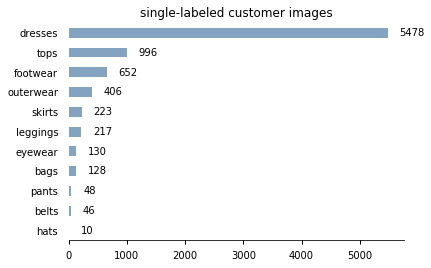

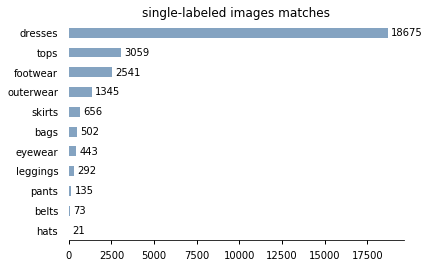

In [25]:
plot_freqs(customer_unique_1, "single-labeled customer images")
plot_freqs(matches_df_unique, "single-labeled images matches")

In [26]:
matches_df_unique = matches_df_unique[matches_df_unique["category"].isin(["dresses", "tops"])]

In [27]:
matches_df.head()

,photo,product,category,id,height,left,top,width,photo_retr,product_retr,category_retr
0,4534,7419,bags,7419_bags,358.0,134.0,172.0,120.0,26524,7419,bags
1,4534,7419,bags,7419_bags,358.0,134.0,172.0,120.0,26525,7419,bags
2,16159,9946,bags,9946_bags,303.0,148.0,184.0,120.0,55512,9946,bags
3,16159,9946,bags,9946_bags,303.0,148.0,184.0,120.0,55514,9946,bags
4,16159,9946,bags,9946_bags,303.0,148.0,184.0,120.0,55516,9946,bags


In [28]:
np.random.seed(2018) #randomly shuffled

perm = np.random.permutation(matches_df_unique['product'].unique()) #permutes list of unique products randomly
split = int(len(matches_df_unique['product'].unique())*0.5) #finding total unique products

print("Total number of unique products per set: ", split)

valid, test = np.split(perm, [split]) #splits list into valid and test
valid_df = matches_df_unique[matches_df_unique['product'].isin(valid)]
test_df = matches_df_unique[matches_df_unique['product'].isin(test)]

Total number of unique products per set:  1666


In [29]:
print("Validation unique products in store:")
print(" - Customer")
print("    Dresses:", valid_df[valid_df["category_retr"] == "dresses"]["product_retr"].unique().shape[0])
print("    Tops:   ", valid_df[valid_df["category_retr"] == "tops"]["product_retr"].unique().shape[0])
print(" - Retrieval unique products in store")
print("    Dresses:", test_df[test_df["category_retr"] == "dresses"]["product_retr"].unique().shape[0])
print("    Tops:   ", test_df[test_df["category_retr"] == "tops"]["product_retr"].unique().shape[0])

Validation unique products in store:
 - Customer
    Dresses: 1320
    Tops:    358
 - Retrieval unique products in store
    Dresses: 1316
    Tops:    366


We have around 1300 unique dresses and ~350 tops, we consider this could fall within the expected volume of products for certain online shopping retailers, so we are satisfied to evaluate the algorithm on these sets. 

This volume will also be consistent on the store application.